In [16]:
import pandas as pd
import numpy as np

# ============================================================
# Define targets (points / xGd )
# Define features: # control/territory ("possession", "field_tilt", "game_control_share")
# Define features: # press ("ppda", "high_recoveries", "on_ball_pressure_share", "off_ball_pressure_share")
# Define features: # threat/entry ("xt", "passes_into_box", "shots_per_1_0_xt")
# Define features: # directness ("avg_pass_height", "crosses")
# Define features: # set pieces ("set_piece_xg", "corners", "throw_ins_into_box")
# Define features: # context ("is_home")
# ============================================================

# 1. Define the base path
base_path = Path.cwd().parent 

# 2. Path to the file
file_path = base_path / "data_processed" / "tableau" / "v_team_match_enriched.csv"

# 3. Read the CSV
try:
    df = pd.read_csv(file_path)
    print(f"✅ File read successfully! Total rows: {len(df)}")

except FileNotFoundError:
    print(f"❌ Error: The file was not found at the path: {file_path}")
except KeyError as e:
    print(f"❌ Error: One or more columns do not exist in the CSV: {e}")

# 4. Define targets
# - points: "real" game success
# - xgd: performance / quality (most stable)
targets = [
    "points",
    "xgd",
]

#5. Define candidate features (style metrics + minimum context)
features = [
    # control/territory
    "possession", "field_tilt", "game_control_share",

    # press
    "ppda", "high_recoveries",
    "on_ball_pressure_share", "off_ball_pressure_share",

    # threat/entry
    "xt", "passes_into_box", "shots_per_1_0_xt",

    # directness
    "avg_pass_height", "crosses",

    # set pieces
    "set_piece_xg", "corners", "throw_ins_into_box",

    # context
    "is_home",
]

# 6. Columns ID / keys (for filters and checks)
keys = [
    "season", "season_id",
    "match_id", "match_date",
    "team_id", "team_name",
    "opponent_team_id", "opponent_team_name",
]

# 7. Build driver-analysis dataset (team×match)
keep_cols = keys + targets + features
team_match = df[keep_cols].copy()

# 8. Ensure numeric data types are used in metrics (prevents hidden strings).
numeric_cols = targets + features
for c in numeric_cols:
    team_match[c] = pd.to_numeric(team_match[c], errors="coerce")

# 9. Create ppda_inv (pressing: greater = more pressure)
team_match["ppda_inv"] = -team_match["ppda"]

# 10. Removing lines with many NaNs in the main features
# here: requires at least 80% of the features filled
min_non_null = int(np.ceil(0.8 * len(features)))
team_match = team_match.dropna(subset=features, thresh=min_non_null)

# 11. Save final dataset to cheklist of TRELLO CARD 10
# If the notebook is in /notebooks, we go up one level to the root.
HERE = Path.cwd()
PROJECT_ROOT = HERE.parent if HERE.name == "notebooks" else HERE

# Define the exact path: 
target_dir = PROJECT_ROOT / "data_processed"
target_dir.mkdir(parents=True, exist_ok=True) 

# Final file name
out_path = target_dir / "team_match_driver_analysis.csv"

# Save
try:
    team_match.to_csv(out_path, index=False)
    print(f"✅ File saved successfully!")
    print(f"📍 Location: {out_path}")
    print(f"📊 Data: {len(team_match)} rows and {team_match.shape[1]} columns.")
except Exception as e:
    print(f"❌ Error saving: {e}")

print("OK:", out_path)
print("Rows:", len(team_match), "| Cols:", team_match.shape[1])
print(team_match.head())
team_match.info()

✅ File read successfully! Total rows: 3040
✅ File saved successfully!
📍 Location: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\team_match_driver_analysis.csv
📊 Data: 3040 rows and 27 columns.
OK: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\team_match_driver_analysis.csv
Rows: 3040 | Cols: 27
  season  season_id                                         match_id  \
0  22-23          2       22-23_2022-01-10_AFC Bournemouth_Brentford   
1  22-23          2       22-23_2022-01-10_AFC Bournemouth_Brentford   
2  22-23          2     22-23_2022-06-08_AFC Bournemouth_Aston Villa   
3  22-23          2     22-23_2022-06-08_AFC Bournemouth_Aston Villa   
4  22-23          2  22-23_2022-08-10_AFC Bournemouth_Leicester City   

   match_date  team_id        team_name  opponent_team_id opponent_team_name  \
0  2022-01-10        1  AFC Bournemouth                 4          Brentford   
1  2022-01-10        4        Brentford                 1    AFC Bour

In [20]:
# ============================================================
# Correlations (Pearson + Spearman) — team × match
# ============================================================

# 1) Define targets (already defined above, but keeping explicit here)
targets = ["points", "xgd"]

# 2) Define candidate features for correlation
#    - We use ppda_inv instead of ppda (higher = more pressing)
corr_features = [
    "possession", "field_tilt", "game_control_share",
    "ppda_inv", "high_recoveries",
    "on_ball_pressure_share", "off_ball_pressure_share",
    "xt", "passes_into_box", "shots_per_1_0_xt",
    "avg_pass_height", "crosses",
    "set_piece_xg", "corners", "throw_ins_into_box",
    "is_home"   # keep as context; we can also run without it later
]

# 3) Helper function: build Pearson + Spearman table
def build_corr_table(df, target, features):
    pearson = df[features].corrwith(df[target], method="pearson")
    spearman = df[features].corrwith(df[target], method="spearman")

    out = pd.DataFrame({
        "feature": features,
        "pearson_r": pearson.values,
        "spearman_rho": spearman.values
    })
    out["abs_spearman"] = out["spearman_rho"].abs()
    out = out.sort_values("abs_spearman", ascending=False).drop(columns=["abs_spearman"]).reset_index(drop=True)
    return out

# 4) Build tables
corr_points = build_corr_table(team_match, "points", corr_features)
corr_xgd = build_corr_table(team_match, "xgd", corr_features)

# 5) Show top results
print("Top correlations with POINTS (sorted by |Spearman|):")
display(corr_points.head(15))

print("Top correlations with XGD (sorted by |Spearman|):")
display(corr_xgd.head(15))

# 6) Save outputs
corr_points_path = target_dir / "corr_points_team_match.csv"
corr_xgd_path = target_dir / "corr_xgd_team_match.csv"

corr_points.to_csv(corr_points_path, index=False)
corr_xgd.to_csv(corr_xgd_path, index=False)

print(f"✅ Saved: {corr_points_path}")
print(f"✅ Saved: {corr_xgd_path}")


Top correlations with POINTS (sorted by |Spearman|):


,feature,pearson_r,spearman_rho
0,game_control_share,0.516256,0.520337
1,on_ball_pressure_share,0.261432,0.264523
2,passes_into_box,0.226959,0.244974
3,xt,0.205768,0.217790
4,field_tilt,0.190590,0.182690
5,avg_pass_height,0.164026,0.156987
6,possession,0.154923,0.153685
7,set_piece_xg,0.120515,0.138334
8,is_home,0.136244,0.137976
9,ppda_inv,0.156544,0.126509


Top correlations with XGD (sorted by |Spearman|):


,feature,pearson_r,spearman_rho
0,game_control_share,0.719851,0.721234
1,on_ball_pressure_share,0.671426,0.678821
2,passes_into_box,0.602243,0.610601
3,xt,0.583088,0.587626
4,field_tilt,0.570258,0.563285
5,possession,0.480341,0.479927
6,avg_pass_height,0.451988,0.435688
7,corners,0.423543,0.421932
8,ppda_inv,0.376835,0.367964
9,off_ball_pressure_share,-0.352986,-0.357850


✅ Saved: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\corr_points_team_match.csv
✅ Saved: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\corr_xgd_team_match.csv


In [21]:
# ============================================================
# Correlations by season (stability check)
# ============================================================

from pathlib import Path

targets = ["points", "xgd"]
corr_features = [
    "possession", "field_tilt", "game_control_share",
    "ppda_inv", "high_recoveries",
    "on_ball_pressure_share", "off_ball_pressure_share",
    "xt", "passes_into_box", "shots_per_1_0_xt",
    "avg_pass_height", "crosses",
    "set_piece_xg", "corners", "throw_ins_into_box",
    "is_home"
]

def corr_by_season(df, target, features, method="spearman"):
    rows = []
    for season, g in df.groupby("season"):
        c = g[features].corrwith(g[target], method=method)
        tmp = pd.DataFrame({"season": season, "feature": c.index, f"{method}": c.values})
        rows.append(tmp)
    out = pd.concat(rows, ignore_index=True)
    return out

def summarize_stability(corr_long, method="spearman"):
    s = (corr_long
         .groupby("feature")[method]
         .agg(mean="mean", std="std", min="min", max="max")
         .reset_index())
    s["mean_abs"] = s["mean"].abs()
    s = s.sort_values("mean_abs", ascending=False).drop(columns=["mean_abs"]).reset_index(drop=True)
    return s

# Build + summarize for each target (Spearman is the main one)
out_dir = target_dir if "target_dir" in globals() else (Path.cwd() / "data_processed")
out_dir.mkdir(parents=True, exist_ok=True)

for t in targets:
    spearman_long = corr_by_season(team_match, t, corr_features, method="spearman")
    pearson_long  = corr_by_season(team_match, t, corr_features, method="pearson")

    spearman_summary = summarize_stability(spearman_long, method="spearman")
    pearson_summary  = summarize_stability(pearson_long, method="pearson")

    # Save
    spearman_long.to_csv(out_dir / f"corr_{t}_spearman_by_season.csv", index=False)
    pearson_long.to_csv(out_dir / f"corr_{t}_pearson_by_season.csv", index=False)
    spearman_summary.to_csv(out_dir / f"corr_{t}_spearman_stability_summary.csv", index=False)
    pearson_summary.to_csv(out_dir / f"corr_{t}_pearson_stability_summary.csv", index=False)

    print(f"\n=== Spearman stability summary for target = {t} (top 12) ===")
    display(spearman_summary.head(12))



=== Spearman stability summary for target = points (top 12) ===


,feature,mean,std,min,max
0,game_control_share,0.520206,0.013746,0.507658,0.538880
1,on_ball_pressure_share,0.263190,0.075542,0.172209,0.340751
2,passes_into_box,0.244591,0.040696,0.189691,0.280247
3,xt,0.216337,0.044641,0.179944,0.275886
4,field_tilt,0.181818,0.077034,0.082868,0.243572
5,avg_pass_height,0.157192,0.034375,0.114785,0.198249
6,possession,0.148373,0.101838,0.022104,0.234119
7,set_piece_xg,0.138648,0.052345,0.089147,0.209215
8,is_home,0.137753,0.067737,0.069646,0.224769
9,high_recoveries,0.134086,0.030899,0.094240,0.169662



=== Spearman stability summary for target = xgd (top 12) ===


,feature,mean,std,min,max
0,game_control_share,0.720544,0.026633,0.701214,0.759758
1,on_ball_pressure_share,0.677225,0.076031,0.582704,0.766587
2,passes_into_box,0.612453,0.045593,0.546498,0.646904
3,xt,0.588598,0.024286,0.554605,0.610618
4,field_tilt,0.562355,0.079214,0.454805,0.645174
5,possession,0.476248,0.082144,0.371912,0.572552
6,avg_pass_height,0.436672,0.049384,0.367349,0.477564
7,corners,0.422474,0.054846,0.350742,0.483213
8,ppda_inv,0.367879,0.057923,0.289474,0.424171
9,crosses,0.356316,0.052318,0.284926,0.408605


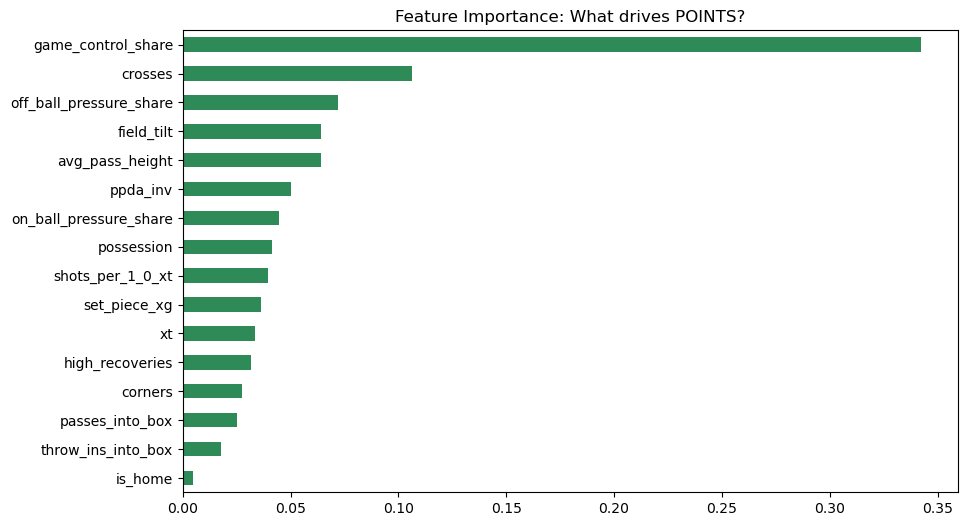

In [24]:
# ============================================================
# Feature importance for "Points" (RandomForestRegressor -  Gini Importance)
# ============================================================

from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Prepare X and y (using the team_match variable)
X = team_match[style_features].fillna(0)
y_points = team_match['points']

# Training and demonstrating importance
rf_points = RandomForestRegressor(n_estimators=100, random_state=42)
rf_points.fit(X, y_points)

importance_points = pd.Series(rf_points.feature_importances_, index=style_features).sort_values(ascending=True)
importance_points.plot(kind='barh', color='seagreen', figsize=(10, 6))
plt.title('Feature Importance: What drives POINTS?')
plt.show()

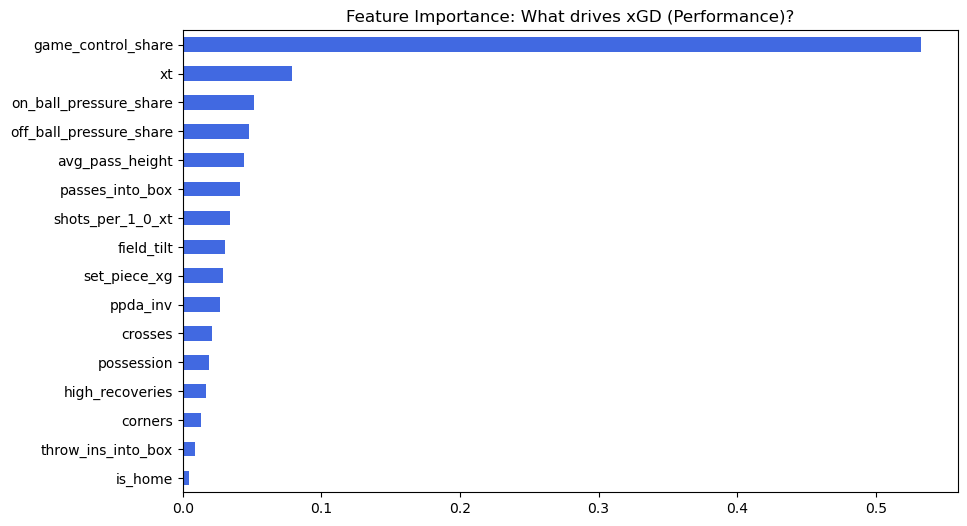

✅ Step 4 completed using 'team_match' variable.


In [25]:
# ============================================================
# Feature importance for "xGd" (RandomForestRegressor -  Gini Importance)
# ============================================================

y_xgd = team_match['xgd']

rf_xgd = RandomForestRegressor(n_estimators=100, random_state=42)
rf_xgd.fit(X, y_xgd)

importance_xgd = pd.Series(rf_xgd.feature_importances_, index=style_features).sort_values(ascending=True)
importance_xgd.plot(kind='barh', color='royalblue', figsize=(10, 6))
plt.title('Feature Importance: What drives xGD (Performance)?')
plt.show()

print("✅ Step 4 completed using 'team_match' variable.")


=== Ridge importance summary (sorted by |mean coef|) — target = points ===


,feature,mean,std,min,max,abs_mean
4,game_control_share,1.166281,0.075095,1.102372,1.270690,1.166281
3,field_tilt,-0.707273,0.168745,-0.872454,-0.541820,0.707273
2,crosses,-0.444115,0.079063,-0.535098,-0.352431,0.444115
10,possession,0.348428,0.233851,0.174544,0.682188,0.348428
7,off_ball_pressure_share,-0.346102,0.135395,-0.494889,-0.174768,0.346102
8,on_ball_pressure_share,-0.329111,0.161078,-0.560917,-0.192104,0.329111
1,corners,0.144412,0.053158,0.078339,0.197765,0.144412
6,is_home,0.103851,0.055760,0.055072,0.183895,0.103851
15,xt,0.077909,0.029141,0.049575,0.115463,0.077909
11,ppda_inv,0.065981,0.042672,0.001981,0.087861,0.065981


✅ Saved: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\ridge_coefs_by_season_points.csv
✅ Saved: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\ridge_importance_summary_points.csv
✅ Saved plot: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\figures\ridge_importance_points.png


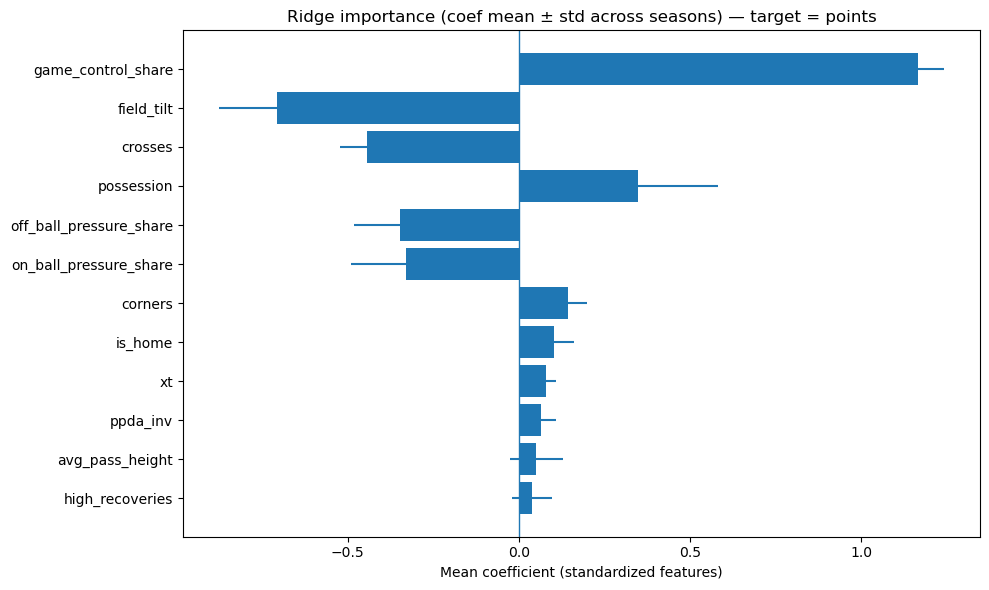


=== Ridge importance summary (sorted by |mean coef|) — target = xgd ===


,feature,mean,std,min,max,abs_mean
3,field_tilt,-0.976878,0.193663,-1.154720,-0.806061,0.976878
4,game_control_share,0.884021,0.196465,0.636224,1.078849,0.884021
8,on_ball_pressure_share,0.872199,0.352360,0.438659,1.275382,0.872199
15,xt,0.353713,0.082947,0.284512,0.456943,0.353713
7,off_ball_pressure_share,-0.246513,0.094645,-0.302489,-0.104895,0.246513
2,crosses,-0.148749,0.027816,-0.173584,-0.110170,0.148749
12,set_piece_xg,0.143014,0.046286,0.086410,0.185569,0.143014
0,avg_pass_height,-0.136096,0.055288,-0.189875,-0.064977,0.136096
11,ppda_inv,0.123126,0.031559,0.091894,0.166630,0.123126
9,passes_into_box,0.096490,0.070130,0.009173,0.175698,0.096490


✅ Saved: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\ridge_coefs_by_season_xgd.csv
✅ Saved: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\ridge_importance_summary_xgd.csv
✅ Saved plot: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\figures\ridge_importance_xgd.png


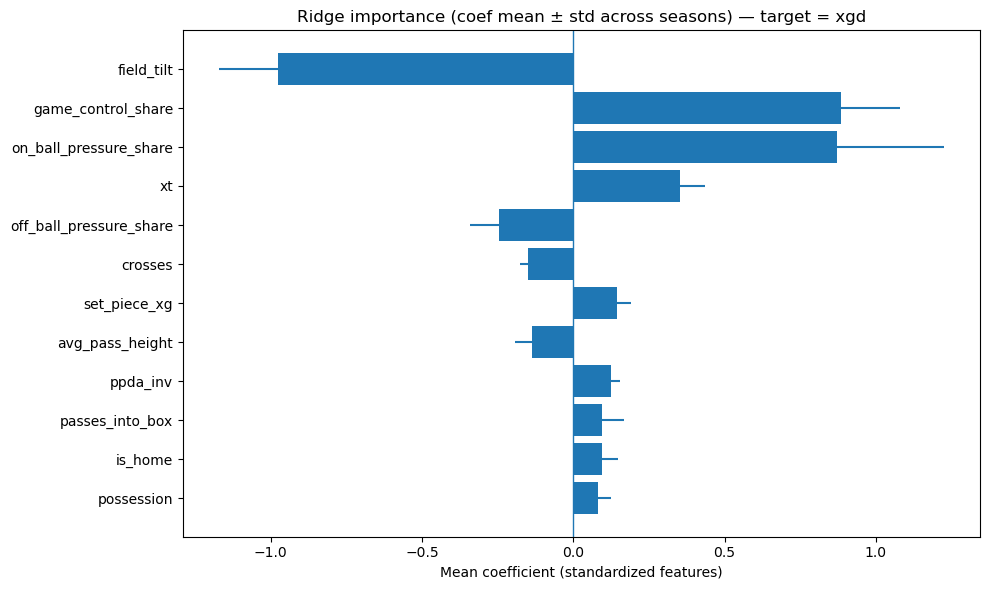

In [22]:
# ============================================================
# Feature importance using Ridge Regression + graphs
# - Adjustment by season (to see stability)
# - Ranking by average |coef| (coef on standardized scale)
# - Exports CSVs + PNGs
# ============================================================

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV

# --- 0) Sanity check
assert "team_match" in globals(), "❌ Não encontrei o DataFrame 'team_match'. Corre a célula anterior primeiro."

# --- 1) Project Root (to save outputs) 
HERE = Path.cwd()
PROJECT_ROOT = HERE.parent if HERE.name == "notebooks" else HERE
OUT_DIR = PROJECT_ROOT / "data_processed"
FIG_DIR = OUT_DIR / "figures"
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# --- 2) Targets 
targets_for_model = ["points", "xgd"]

# --- 3) Features for the model (important: use ppda_inv and NOT ppda, to avoid duplication)
model_features = [
    # control/territory
    "possession", "field_tilt", "game_control_share",

    # press
    "ppda_inv", "high_recoveries",
    "on_ball_pressure_share", "off_ball_pressure_share",

    # threat/entry
    "xt", "passes_into_box", "shots_per_1_0_xt",

    # directness
    "avg_pass_height", "crosses",

    # set pieces
    "set_piece_xg", "corners", "throw_ins_into_box",

    # context
    "is_home",
]

# --- 4) Function: Ridge per season + summary (average/standard/minimum/maximum of coefficients)
def ridge_importance_by_season(df: pd.DataFrame, target: str, features: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    rows = []
    seasons = sorted(df["season"].unique())

    alphas = np.logspace(-3, 3, 50)

    for s in seasons:
        d = df[df["season"] == s].copy()
        d = d.dropna(subset=[target] + features)

        X = d[features].astype(float)
        y = d[target].astype(float)

        # Pipeline: standardize -> RidgeCV (coef = importância "por 1 desvio-padrão")
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", RidgeCV(alphas=alphas, cv=5))
        ])

        pipe.fit(X, y)

        coefs = pipe.named_steps["ridge"].coef_
        alpha_sel = pipe.named_steps["ridge"].alpha_

        for feat, coef in zip(features, coefs):
            rows.append({
                "season": s,
                "target": target,
                "feature": feat,
                "coef": float(coef),
                "abs_coef": float(abs(coef)),
                "alpha": float(alpha_sel),
                "n_rows": int(len(d))
            })

    coef_df = pd.DataFrame(rows)

    summary = (
        coef_df.groupby("feature")["coef"]
        .agg(mean="mean", std="std", min="min", max="max")
        .reset_index()
    )
    summary["abs_mean"] = summary["mean"].abs()
    summary = summary.sort_values("abs_mean", ascending=False)

    return coef_df, summary

# --- 5) Plot helper
def plot_top_importance(summary: pd.DataFrame, target: str, top_n: int = 12, save_path: Path | None = None):
    plot_df = summary.head(top_n).copy()
    plot_df = plot_df.iloc[::-1]  # para o mais forte ficar em cima no barh

    y = np.arange(len(plot_df))

    plt.figure(figsize=(10, 6))
    plt.barh(y, plot_df["mean"])
    plt.errorbar(plot_df["mean"], y, xerr=plot_df["std"], fmt="none")  # sem cores fixas
    plt.yticks(y, plot_df["feature"])
    plt.axvline(0, linewidth=1)
    plt.title(f"Ridge importance (coef mean ± std across seasons) — target = {target}")
    plt.xlabel("Mean coefficient (standardized features)")
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=160)
        print(f"✅ Saved plot: {save_path}")

    plt.show()

# --- 6) Run for each target + save outputs
for tgt in targets_for_model:
    coef_df, summary_df = ridge_importance_by_season(team_match, tgt, model_features)

    # Save CSVs
    coef_path = OUT_DIR / f"ridge_coefs_by_season_{tgt}.csv"
    summary_path = OUT_DIR / f"ridge_importance_summary_{tgt}.csv"
    coef_df.to_csv(coef_path, index=False)
    summary_df.to_csv(summary_path, index=False)

    print(f"\n=== Ridge importance summary (sorted by |mean coef|) — target = {tgt} ===")
    display(summary_df.head(15))

    print(f"✅ Saved: {coef_path}")
    print(f"✅ Saved: {summary_path}")

    # Save + show plots
    fig_path = FIG_DIR / f"ridge_importance_{tgt}.png"
    plot_top_importance(summary_df, tgt, top_n=12, save_path=fig_path)



=== Permutation importance summary — target = points ===


,feature,mean,std,min,max
14,throw_ins_into_box,0.000117,0.000282,-0.000055,0.000535
9,passes_into_box,-0.000505,0.004807,-0.006500,0.004677
13,shots_per_1_0_xt,-0.001169,0.001665,-0.003587,0.000029
12,set_piece_xg,-0.003131,0.002429,-0.005651,0.000049
11,ppda_inv,-0.004958,0.003635,-0.008556,0.000028
5,high_recoveries,-0.006350,0.006308,-0.014226,-0.000029
15,xt,-0.009314,0.004733,-0.014694,-0.004756
0,avg_pass_height,-0.011456,0.014345,-0.031809,-0.000923
6,is_home,-0.013879,0.013007,-0.033128,-0.004893
1,corners,-0.022051,0.012157,-0.037667,-0.009082


✅ Saved plot: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\figures\perm_importance_points.png


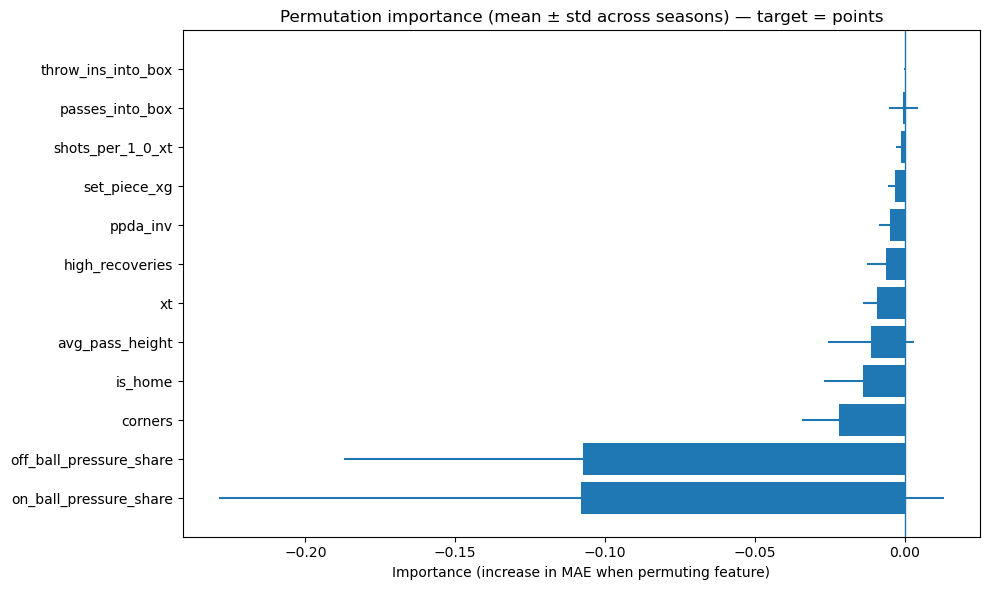

✅ Saved: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\perm_importance_by_season_points.csv
✅ Saved: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\perm_importance_summary_points.csv

=== Permutation importance summary — target = xgd ===


,feature,mean,std,min,max
5,high_recoveries,-0.001199,0.001155,-0.002750,0.000009
1,corners,-0.003736,0.006999,-0.014160,0.000792
13,shots_per_1_0_xt,-0.004920,0.006176,-0.014013,-0.000218
14,throw_ins_into_box,-0.005170,0.005543,-0.012516,-0.000162
10,possession,-0.008495,0.009454,-0.022507,-0.001873
9,passes_into_box,-0.010476,0.013772,-0.030698,-0.000045
6,is_home,-0.011562,0.011221,-0.026138,-0.000015
11,ppda_inv,-0.013882,0.008991,-0.025429,-0.004105
0,avg_pass_height,-0.017824,0.011432,-0.029831,-0.005643
12,set_piece_xg,-0.019269,0.009130,-0.029958,-0.007674


✅ Saved plot: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\figures\perm_importance_xgd.png


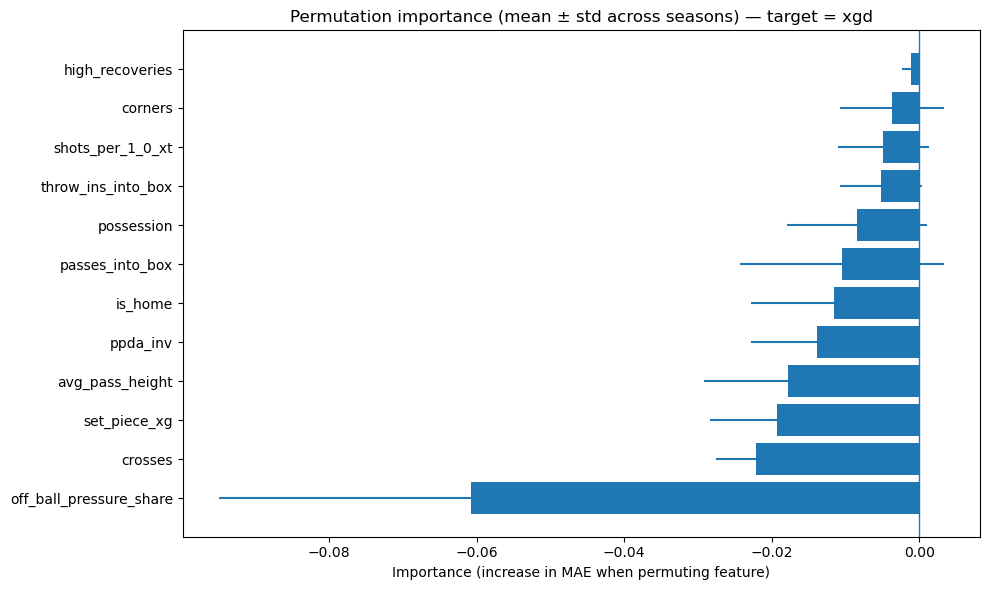

✅ Saved: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\perm_importance_by_season_xgd.csv
✅ Saved: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\perm_importance_summary_xgd.csv


In [23]:
# ============================================================
# Extra: Permutation Importance (CV) por época + gráficos
# ============================================================

from sklearn.model_selection import KFold, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- paths 
assert "FIG_DIR" in globals() and "OUT_DIR" in globals()

# --- config
targets_for_perm = ["points", "xgd"]
features_perm = model_features  # usa as mesmas do Ridge
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # negativo (sklearn)

def permutation_by_season(df, target, features, n_repeats=20, random_state=42):
    rows = []
    seasons = sorted(df["season"].unique())

    for s in seasons:
        d = df[df["season"] == s].dropna(subset=[target] + features).copy()
        X = d[features].astype(float)
        y = d[target].astype(float)

        # modelo base (simples e robusto)
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=1.0, random_state=random_state))
        ])

        # fit
        model.fit(X, y)

        # permutation importance: impact on score (negative MAE -> the more negative, the worse)
        # Let's measure "decrease in score" => more negative means worse -> positive importance
        perm = permutation_importance(
            model, X, y,
            scoring=mae_scorer,
            n_repeats=n_repeats,
            random_state=random_state
        )

        for feat, imp_mean, imp_std in zip(features, perm.importances_mean, perm.importances_std):
            # Since the score is negative, a "worsening" appears as a more negative value.
            # To make it intuitive, we invert the sign:
            rows.append({
                "season": s,
                "target": target,
                "feature": feat,
                "perm_mean": float(-imp_mean),
                "perm_std": float(imp_std),
                "n_rows": int(len(d))
            })

    df_perm = pd.DataFrame(rows)
    summary = (
        df_perm.groupby("feature")["perm_mean"]
        .agg(mean="mean", std="std", min="min", max="max")
        .reset_index()
        .sort_values("mean", ascending=False)
    )
    return df_perm, summary

def plot_perm(summary, target, top_n=12, save_path=None):
    plot_df = summary.head(top_n).copy().iloc[::-1]
    y = np.arange(len(plot_df))

    plt.figure(figsize=(10, 6))
    plt.barh(y, plot_df["mean"])
    plt.errorbar(plot_df["mean"], y, xerr=plot_df["std"], fmt="none")
    plt.yticks(y, plot_df["feature"])
    plt.axvline(0, linewidth=1)
    plt.title(f"Permutation importance (mean ± std across seasons) — target = {target}")
    plt.xlabel("Importance (increase in MAE when permuting feature)")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=160)
        print(f"✅ Saved plot: {save_path}")
    plt.show()

for tgt in targets_for_perm:
    df_perm, perm_summary = permutation_by_season(team_match, tgt, features_perm, n_repeats=25)

    perm_path = OUT_DIR / f"perm_importance_by_season_{tgt}.csv"
    perm_sum_path = OUT_DIR / f"perm_importance_summary_{tgt}.csv"
    df_perm.to_csv(perm_path, index=False)
    perm_summary.to_csv(perm_sum_path, index=False)

    print(f"\n=== Permutation importance summary — target = {tgt} ===")
    display(perm_summary.head(15))

    fig_path = FIG_DIR / f"perm_importance_{tgt}.png"
    plot_perm(perm_summary, tgt, top_n=12, save_path=fig_path)

    print(f"✅ Saved: {perm_path}")
    print(f"✅ Saved: {perm_sum_path}")


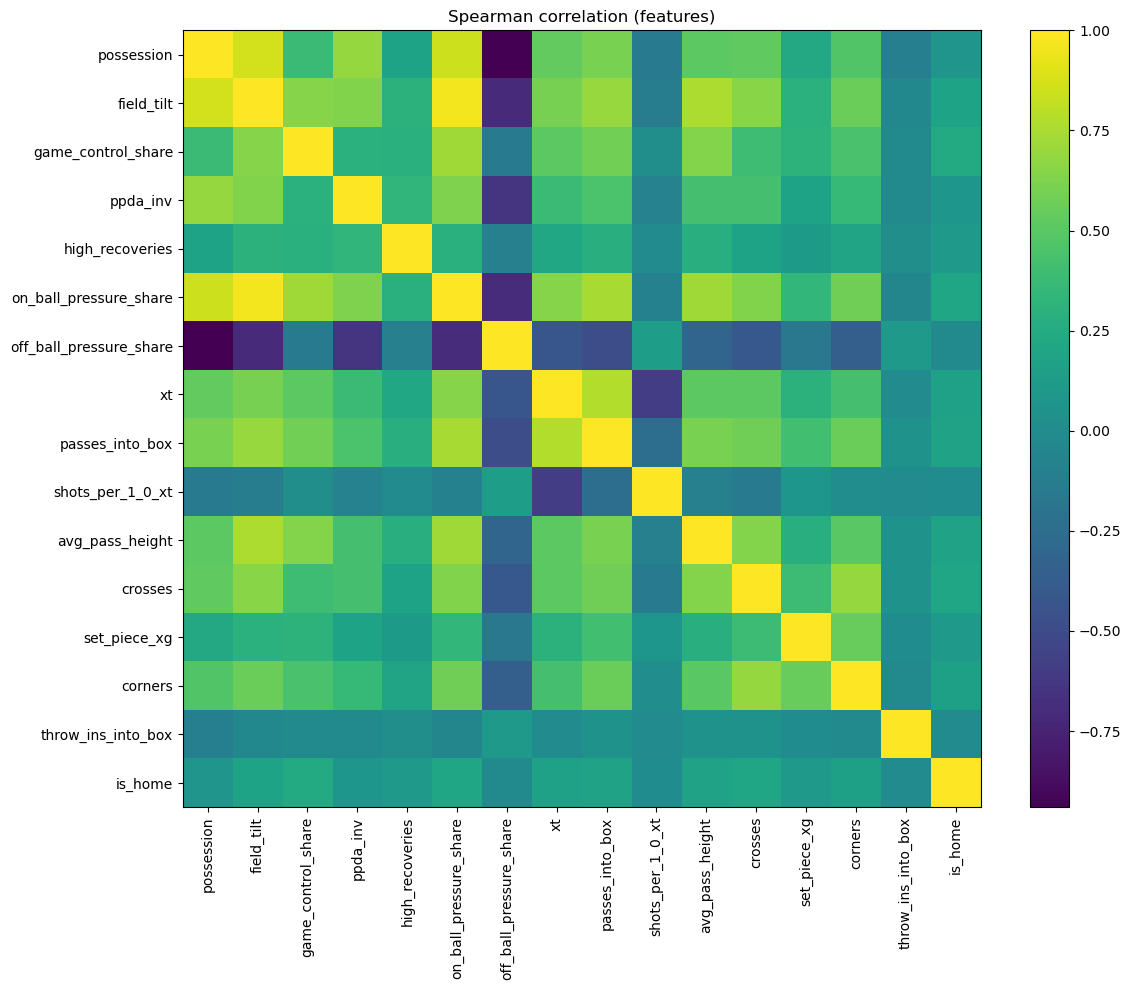

,feat_a,feat_b,spearman_r
3,field_tilt,on_ball_pressure_share,0.964643
2,possession,off_ball_pressure_share,-0.940005
0,possession,field_tilt,0.867827
1,possession,on_ball_pressure_share,0.855995


In [26]:
# ============================================================
# Heatmap Spearman among features to detect multicollinearity.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# using features the driver dataset (including ppda_inv)
feat_cols = [
    "possession","field_tilt","game_control_share",
    "ppda_inv","high_recoveries",
    "on_ball_pressure_share","off_ball_pressure_share",
    "xt","passes_into_box","shots_per_1_0_xt",
    "avg_pass_height","crosses",
    "set_piece_xg","corners","throw_ins_into_box",
    "is_home"
]

corr = team_match[feat_cols].corr(method="spearman")

# heatmap (matplotlib)
plt.figure(figsize=(12,10))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(feat_cols)), feat_cols, rotation=90)
plt.yticks(range(len(feat_cols)), feat_cols)
plt.colorbar()
plt.title("Spearman correlation (features)")
plt.tight_layout()
plt.show()

# list of pairs with high correlation
thr = 0.85
pairs = []
for i in range(len(feat_cols)):
    for j in range(i+1, len(feat_cols)):
        r = corr.iloc[i,j]
        if abs(r) >= thr:
            pairs.append((feat_cols[i], feat_cols[j], r))
pairs_df = pd.DataFrame(pairs, columns=["feat_a","feat_b","spearman_r"]).sort_values("spearman_r", key=lambda s: s.abs(), ascending=False)
pairs_df


In [27]:
# ============================================================
# Resource selection for defining a final (reduced) set to avoid redundancies (multicollinearity).
# ============================================================
feature_set_final = [
    # control/territory
    "game_control_share",
    "field_tilt",              # Keep field_tilt and take possession + on_ball_pressure_share
    "off_ball_pressure_share",

    # press
    "ppda_inv",
    "high_recoveries",

    # threat/entry
    "xt",
    "passes_into_box",
    "shots_per_1_0_xt",

    # directness
    "avg_pass_height",
    "crosses",

    # set pieces
    "set_piece_xg",
    "corners",
    "throw_ins_into_box",
]

# dataset for clustering/driver analysis (without target/keys)
X_final = team_match[feature_set_final].copy()

print("Final features:", len(feature_set_final))
display(pd.DataFrame({"feature": feature_set_final}))


Final features: 13


,feature
0,game_control_share
1,field_tilt
2,off_ball_pressure_share
3,ppda_inv
4,high_recoveries
5,xt
6,passes_into_box
7,shots_per_1_0_xt
8,avg_pass_height
9,crosses


In [28]:
# 1) final list of features (the one we define)
feature_set_final = [
    "game_control_share",
    "field_tilt",
    "off_ball_pressure_share",
    "ppda_inv",
    "high_recoveries",
    "xt",
    "passes_into_box",
    "shots_per_1_0_xt",
    "avg_pass_height",
    "crosses",
    "set_piece_xg",
    "corners",
    "throw_ins_into_box",
]

# 2) Derived dataset (team×match) with only final features + keys (useful for debugging)
team_match_selected = team_match[keys + feature_set_final].copy()

# 3) (optional) save separate CSV
out_selected = target_dir / "team_match_driver_analysis_selected_features.csv"
team_match_selected.to_csv(out_selected, index=False)
print("✅ Saved:", out_selected, "| rows:", len(team_match_selected), "| cols:", team_match_selected.shape[1])


✅ Saved: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\team_match_driver_analysis_selected_features.csv | rows: 3040 | cols: 21


In [29]:
from pathlib import Path
import pandas as pd
import numpy as np

# --- 1) Read the team×season (80 lines) ---
base_path = Path.cwd().parent
season_file = base_path / "data_processed" / "tableau" / "v_style_clustering_input.csv"

team_season_raw = pd.read_csv(season_file)
print("✅ team_season_raw:", team_season_raw.shape)

# --- 2) IDs + final feature set  (use z_ para KMeans) ---
id_cols = ["season_id", "season", "team_id", "team_name", "matches_played"]

# Final Feature set (remove strong redundancies: ex. possession and on_ball_pressure_share)
features_final_z = [
    "z_game_control_share",
    "z_field_tilt",
    "z_off_ball_pressure_share",
    "z_ppda_inv",
    "z_high_recoveries",
    "z_xt",
    "z_passes_into_box",
    "z_shots_per_1_0_xt",
    "z_avg_pass_height",
    "z_crosses",
    "z_set_piece_xg",
    "z_corners",
    "z_throw_ins_into_box",
]

# --- 3) Dataset for clustering ---
team_season = team_season_raw[id_cols + features_final_z].copy()

# guarantee numerics
for c in features_final_z:
    team_season[c] = pd.to_numeric(team_season[c], errors="coerce")

# Remove lines with NaN in features.
team_season = team_season.dropna(subset=features_final_z)

print("✅ team_season (clustering input):", team_season.shape)
display(team_season.head())

# --- 4) Save the derived CSV (does not replace the master) ---
target_dir = base_path / "data_processed"
target_dir.mkdir(parents=True, exist_ok=True)

out_path = target_dir / "team_season_clustering_input_z.csv"
team_season.to_csv(out_path, index=False)

print("✅ Saved:", out_path)


✅ team_season_raw: (80, 54)
✅ team_season (clustering input): (80, 18)


,season_id,season,team_id,team_name,matches_played,z_game_control_share,z_field_tilt,z_off_ball_pressure_share,z_ppda_inv,z_high_recoveries,z_xt,z_passes_into_box,z_shots_per_1_0_xt,z_avg_pass_height,z_crosses,z_set_piece_xg,z_corners,z_throw_ins_into_box
0,1,21-22,19,Norwich City,38,-1.665326,-1.330004,0.674886,-1.170661,-1.872857,-1.208955,-0.923705,1.283107,-1.548235,-1.188529,-1.443905,-0.776542,-0.614858
1,1,21-22,24,Watford,38,-0.503623,-0.991478,1.437589,-1.203212,-1.201581,-0.822232,-1.107273,0.221015,-0.602189,-0.766108,-1.030230,-0.871710,-0.208308
2,1,21-22,26,Wolverhampton Wanderers,38,-0.778682,-0.437312,-0.176334,-0.923269,-0.832463,-0.891810,-1.055878,0.048827,-1.028460,-0.945638,-1.076994,-0.705144,-0.919834
3,1,21-22,6,Burnley,38,-0.229945,-0.695745,1.561944,-0.271914,0.577306,-0.480815,-0.578611,-0.168203,0.840044,0.765073,0.426625,-0.348424,0.841923
4,1,21-22,13,Leicester City,38,-1.077113,-0.412473,-0.582795,-0.065212,0.208060,-0.374021,-0.578611,-0.079727,-0.982025,-1.325805,-0.832386,-0.300885,-0.818132


✅ Saved: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\team_season_clustering_input_z.csv


C:\Users\tozes\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não conseguiu localizar o ficheiro especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\tozes\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\tozes\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tozes\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^

,k,inertia,silhouette
0,2,592.466912,0.323087
1,3,473.652030,0.233195
2,4,404.524195,0.231164
3,5,362.410290,0.245923
4,6,328.951624,0.238223
5,7,306.823595,0.188120
6,8,285.527882,0.189965


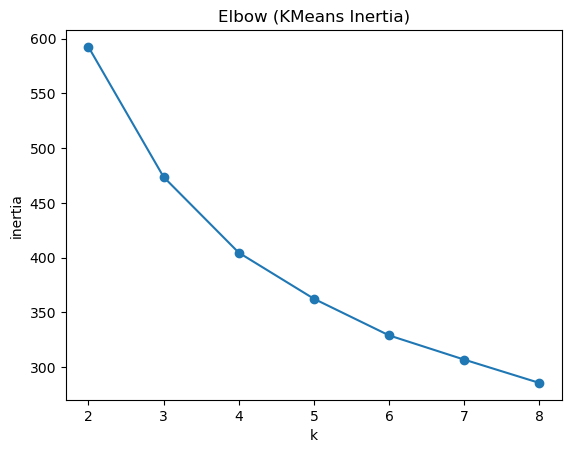

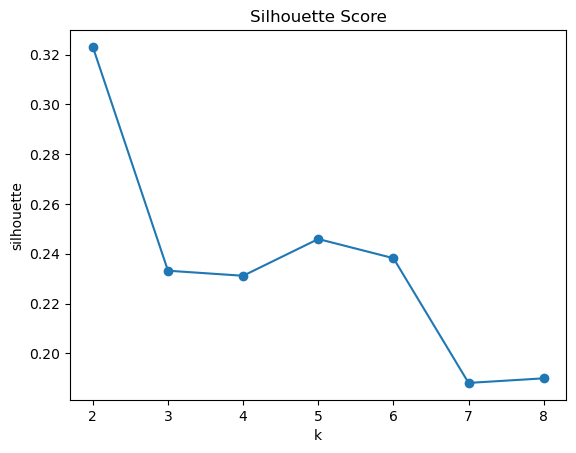

✅ Suggested k (max silhouette): 2


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Matriz X (using z-scores) ---
X = team_season[features_final_z].to_numpy()

# --- Testing several K ---
k_range = range(2, 9)  # 2..8 
rows = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = km.fit_predict(X)
    inertia = km.inertia_
    sil = silhouette_score(X, labels)
    rows.append({"k": k, "inertia": inertia, "silhouette": sil})

metrics = pd.DataFrame(rows).sort_values("k")
display(metrics)

# --- Gráficos: Elbow (inertia) + Silhouette ---
plt.figure()
plt.plot(metrics["k"], metrics["inertia"], marker="o")
plt.title("Elbow (KMeans Inertia)")
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(list(k_range))
plt.show()

plt.figure()
plt.plot(metrics["k"], metrics["silhouette"], marker="o")
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.xticks(list(k_range))
plt.show()

# --- Automatic suggestion (maximum silhouette) ---
k_best = int(metrics.loc[metrics["silhouette"].idxmax(), "k"])
print("✅ Suggested k (max silhouette):", k_best)


In [31]:
# ============================================================
# Cluster Signature
# ============================================================

from sklearn.cluster import KMeans

# features raw 
raw_features = [
    "possession","field_tilt","game_control_share",
    "ppda","high_recoveries","on_ball_pressure_share","off_ball_pressure_share",
    "xt","passes_into_box","shots_per_1_0_xt",
    "avg_pass_height","crosses",
    "set_piece_xg","corners","throw_ins_into_box",
    "xgd"
]

# (Optional) also creates ppda_inv in raw for easy reading.
if "ppda_inv" not in team_season_raw.columns and "ppda" in team_season_raw.columns:
    team_season_raw["ppda_inv"] = -team_season_raw["ppda"]

def run_and_save(k):
    km = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = km.fit_predict(X)

    out = team_season_raw.copy()
    out["cluster_id"] = labels

    # 1) distribution of clusters
    print(f"\n=== k={k} | cluster sizes ===")
    print(out["cluster_id"].value_counts().sort_index())

    # 2) SIGNATURE (raw means)
    sig = out.groupby("cluster_id")[raw_features].mean().round(3).reset_index()

    # 3) save files
    out_path = target_dir / f"team_season_clusters_k{k}.csv"
    sig_path = target_dir / f"cluster_signature_k{k}.csv"

    out.to_csv(out_path, index=False)
    sig.to_csv(sig_path, index=False)

    print(f"✅ Saved team×season clusters: {out_path}")
    print(f"✅ Saved cluster signature:   {sig_path}")

    return out, sig

clusters_k2, sig_k2 = run_and_save(2)
clusters_k5, sig_k5 = run_and_save(5)

display(sig_k2)
display(sig_k5)


C:\Users\tozes\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



=== k=2 | cluster sizes ===
cluster_id
0    28
1    52
Name: count, dtype: int64
✅ Saved team×season clusters: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\team_season_clusters_k2.csv
✅ Saved cluster signature:   C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\cluster_signature_k2.csv


C:\Users\tozes\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



=== k=5 | cluster sizes ===
cluster_id
0    27
1    22
2    15
3    11
4     5
Name: count, dtype: int64
✅ Saved team×season clusters: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\team_season_clusters_k5.csv
✅ Saved cluster signature:   C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\cluster_signature_k5.csv


,cluster_id,possession,field_tilt,game_control_share,ppda,high_recoveries,on_ball_pressure_share,off_ball_pressure_share,xt,passes_into_box,shots_per_1_0_xt,avg_pass_height,crosses,set_piece_xg,corners,throw_ins_into_box,xgd
0,0,57.122,59.682,62.752,11.674,8.327,66.961,35.720,0.843,17.285,22.642,49.240,19.289,0.283,6.233,0.510,0.709
1,1,46.165,44.787,43.133,15.111,7.040,40.867,57.689,0.605,11.515,22.822,46.051,16.769,0.213,4.630,1.003,-0.382


,cluster_id,possession,field_tilt,game_control_share,ppda,high_recoveries,on_ball_pressure_share,off_ball_pressure_share,xt,passes_into_box,shots_per_1_0_xt,avg_pass_height,crosses,set_piece_xg,corners,throw_ins_into_box,xgd
0,0,52.206,51.579,50.580,12.878,7.657,53.570,43.581,0.718,14.034,21.989,46.973,17.986,0.225,5.429,0.542,0.113
1,1,44.876,42.318,38.180,15.767,6.219,36.445,59.501,0.526,10.108,24.824,45.145,15.033,0.177,4.155,0.804,-0.739
2,2,60.826,64.718,70.227,11.255,9.218,75.428,28.806,0.930,19.468,23.220,50.370,19.828,0.323,6.782,0.539,1.155
3,3,42.572,44.881,49.824,15.875,6.830,39.795,71.299,0.608,11.218,24.208,47.970,19.053,0.267,4.844,1.129,-0.322
4,4,44.495,42.384,38.580,14.922,8.458,36.534,59.579,0.698,13.211,13.263,45.741,17.742,0.249,4.447,2.726,-0.116


,cluster_id,top_features,bottom_features
0,0,"possession, on_ball_pressure_share, corners, xt","ppda, throw_ins_into_box, off_ball_pressure_sh..."
1,1,"ppda, off_ball_pressure_share, shots_per_1_0_x...","crosses, xt, corners, xgd"
2,2,"passes_into_box, field_tilt, on_ball_pressure_...","off_ball_pressure_share, ppda, throw_ins_into_..."
3,3,"off_ball_pressure_share, ppda, crosses, set_pi...","possession, on_ball_pressure_share, passes_int..."
4,4,"throw_ins_into_box, off_ball_pressure_share, p...","shots_per_1_0_xt, game_control_share, on_ball_..."


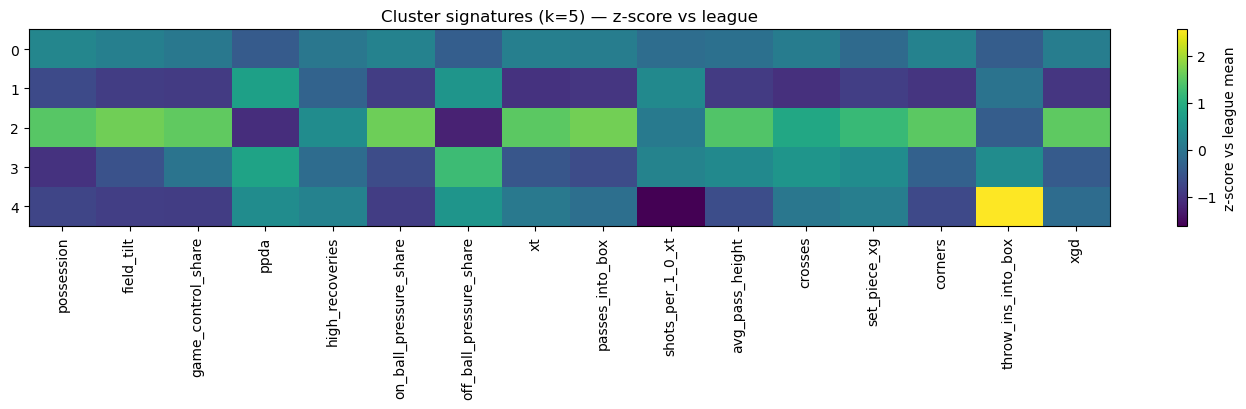

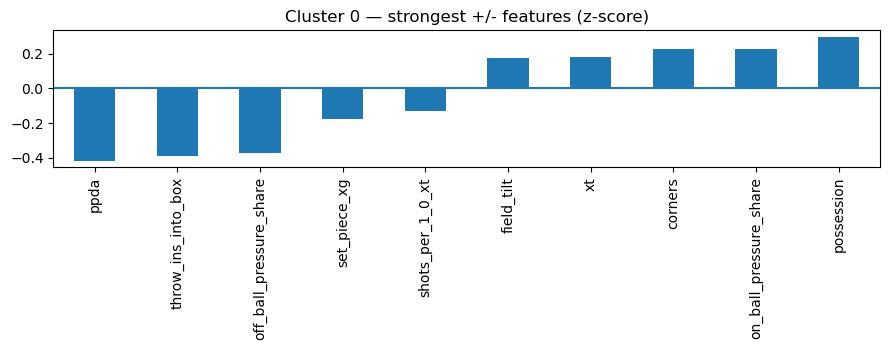

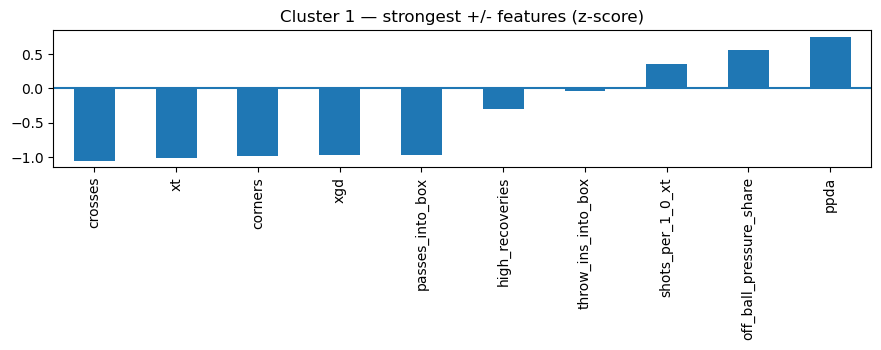

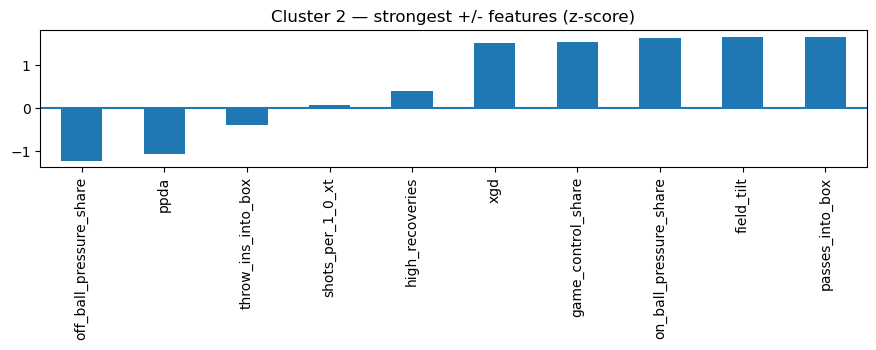

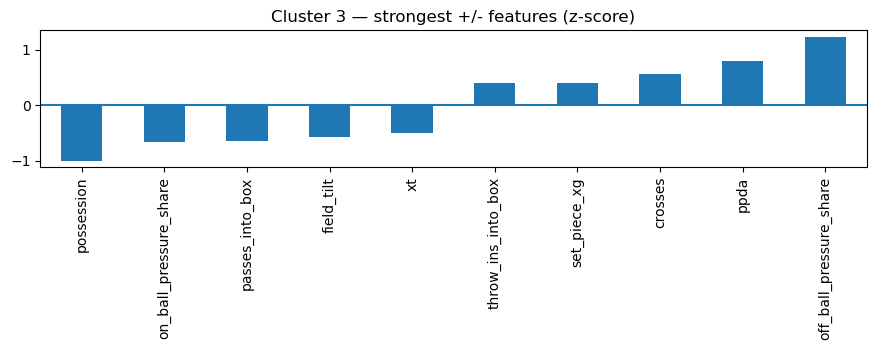

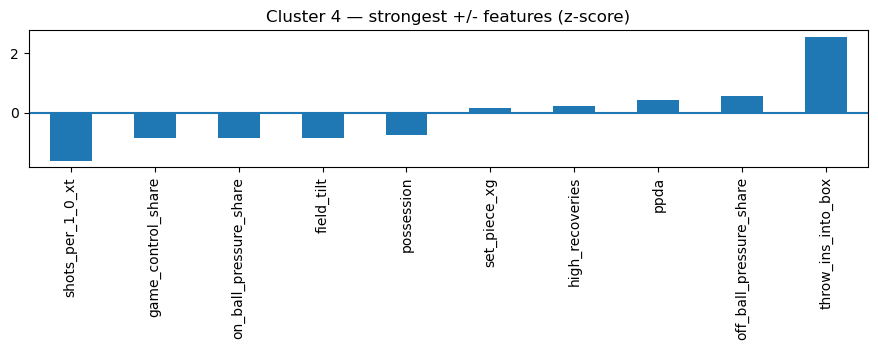

✅ Saved: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\cluster_labels_k5.csv
✅ Saved: C:\Users\tozes\Documents\IronHack\pl_21-25_analysis\data_processed\team_season_clusters_k5_labeled.csv


,season_id,season,team_id,team_name,matches_played,possession,field_tilt,game_control_share,ppda,high_recoveries,...,pct_passes_into_box,pct_shots_per_1_0_xt,pct_avg_pass_height,pct_crosses,pct_set_piece_xg,pct_corners,pct_throw_ins_into_box,pct_xgd,cluster_id,cluster_label
0,1,21-22,19,Norwich City,38,42.813158,37.698684,26.841842,17.623421,3.4211,...,10.526316,89.473684,0.000000,5.263158,0.000000,21.052632,26.315789,0.000000,1,Low control + low threat
1,1,21-22,24,Watford,38,40.665789,40.829737,42.996579,17.702368,3.9474,...,0.000000,73.684211,31.578947,21.052632,10.526316,10.526316,57.894737,5.263158,1,Low control + low threat
2,1,21-22,26,Wolverhampton Wanderers,38,49.531579,45.955263,39.171579,17.023421,4.2368,...,5.263158,63.157895,15.789474,10.526316,5.263158,26.315789,0.000000,10.526316,1,Low control + low threat
3,1,21-22,6,Burnley,38,40.060526,43.565000,46.802368,15.443684,5.3421,...,26.315789,42.105263,89.473684,84.210526,73.684211,42.105263,89.473684,15.789474,3,Reactive / defensive + wide-direct
4,1,21-22,13,Leicester City,38,51.997368,46.185000,35.021579,14.942368,5.0526,...,26.315789,52.631579,21.052632,0.000000,21.052632,47.368421,5.263158,21.052632,1,Low control + low threat


In [32]:
# ============================================================
# Cluster labels (k=5) — interpretar + guardar para Tableau
# ============================================================

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- paths
HERE = Path.cwd()
PROJECT_ROOT = HERE.parent if HERE.name == "notebooks" else HERE

sig_path = PROJECT_ROOT / "data_processed" / "cluster_signature_k5.csv"
clusters_path = PROJECT_ROOT / "data_processed" / "team_season_clusters_k5.csv"

sig = pd.read_csv(sig_path)

# ensure that cluster_id exists
if "cluster_id" not in sig.columns:
    raise ValueError("cluster_signature_k5.csv precisa da coluna 'cluster_id'.")

sig["cluster_id"] = sig["cluster_id"].astype(int)
sig = sig.sort_values("cluster_id").reset_index(drop=True)

# "Official" list of metrics (ignore any that are missing from the file)
metric_cols = [
    "possession","field_tilt","game_control_share","ppda","high_recoveries",
    "on_ball_pressure_share","off_ball_pressure_share","xt","passes_into_box",
    "shots_per_1_0_xt","avg_pass_height","crosses","set_piece_xg","corners",
    "throw_ins_into_box","xgd"
]
metric_cols = [c for c in metric_cols if c in sig.columns]

# --- Choose a baseline for comparison (league mean/standard deviation) and calculate the signature's z-score.
# Try using team_season_raw (if it exists in the notebook), otherwise try searching for v_style_clustering_input.csv
if "team_season_raw" in globals():
    base = team_season_raw.copy()
else:
    # Folder where the CSV files for Tableau
    base_path = PROJECT_ROOT / "data_processed" / "tableau" / "v_style_clustering_input.csv"
    base = pd.read_csv(base_path)

mu = base[metric_cols].mean(numeric_only=True)
sd = base[metric_cols].std(numeric_only=True).replace(0, np.nan)

sig_z = sig[["cluster_id"]].copy()
sig_z[metric_cols] = (sig[metric_cols] - mu) / sd

# --- helper: top/bottom drivers per cluster (z)
def top_bottom_features(row, k=4):
    s = row[metric_cols].sort_values()
    bottom = list(s.head(k).index)
    top = list(s.tail(k).index[::-1])
    return top, bottom

profiles = []
for _, r in sig_z.iterrows():
    top, bottom = top_bottom_features(r, k=4)
    profiles.append({
        "cluster_id": int(r["cluster_id"]),
        "top_features": ", ".join(top),
        "bottom_features": ", ".join(bottom)
    })

profiles_df = pd.DataFrame(profiles).sort_values("cluster_id")
display(profiles_df)

# --- VISUAL 1: heatmap (z-score vs liga)
Z = sig_z.set_index("cluster_id")[metric_cols]

plt.figure(figsize=(14, 4.2))
plt.imshow(Z.values, aspect="auto")
plt.colorbar(label="z-score vs league mean")
plt.yticks(range(len(Z.index)), Z.index)
plt.xticks(range(len(metric_cols)), metric_cols, rotation=90)
plt.title("Cluster signatures (k=5) — z-score vs league")
plt.tight_layout()
plt.show()

# --- VISUAL 2: barras top +/- por cluster
for cid in Z.index:
    s = Z.loc[cid].sort_values()
    sel = pd.concat([s.head(5), s.tail(5)])
    plt.figure(figsize=(9, 3.6))
    sel.plot(kind="bar")
    plt.axhline(0)
    plt.title(f"Cluster {cid} — strongest +/- features (z-score)")
    plt.tight_layout()
    plt.show()

# --- Labels names
# NOTE: cluster_id is "arbitrary" (it may change if we retrain the model). Confirmed by signature/heatmap.
label_map = {
    2: "Dominant control + high press",
    0: "Balanced / mid-control",
    1: "Low control + low threat",
    3: "Reactive / defensive + wide-direct",
    4: "Set-piece & throw-in focused"
}

cluster_labels = (
    pd.DataFrame({"cluster_id": sorted(sig["cluster_id"].unique())})
      .assign(cluster_label=lambda d: d["cluster_id"].map(label_map))
)

# If any result is NaN (because the ID doesn't match), fill it with "Cluster X".
cluster_labels["cluster_label"] = cluster_labels["cluster_label"].fillna(
    cluster_labels["cluster_id"].apply(lambda x: f"Cluster {x}")
)

# save labels
out_labels = PROJECT_ROOT / "data_processed" / "cluster_labels_k5.csv"
cluster_labels.to_csv(out_labels, index=False)
print("✅ Saved:", out_labels)

# Add labels to the dataset team×season (for Tableau)
clusters = pd.read_csv(clusters_path)
clusters_labeled = clusters.merge(cluster_labels, on="cluster_id", how="left")

out_clusters_labeled = PROJECT_ROOT / "data_processed" / "team_season_clusters_k5_labeled.csv"
clusters_labeled.to_csv(out_clusters_labeled, index=False)
print("✅ Saved:", out_clusters_labeled)

display(clusters_labeled.head())
